# Clipping a Grid


Example of how to use `rioxarray` to clip the drainage basins from Antarctica, using the Rinot basins shapefile, avaibale at the [IMBIE website](http://imbie.org/imbie-2016/drainage-basins/)

In [3]:
import pandas as pd
import numpy as np

import xarray as xr # working with netcdf and arrays 
import rioxarray # to clip
import shapefile # to read the shapefile 
from pyproj import Transformer # to transform the coordinates 
# plotting
from cartopy import crs as ccrs#, feature as cfeature
from matplotlib import pyplot as plt
import matplotlib.path as mpath

In [2]:
# open etopo dataset
ds=xr.open_dataset('/Users/ccamargo/Documents/github/oceanmass_SLF_local/data/ETOPO1_Ice-180x360.nc')
# creade dataarray to clip:
xda = xr.DataArray(data=ds.z, 
                       dims=["y", "x"], 
                       coords=dict(x=(["x"], ds.lon),
                                   y=(["y"], ds.lat)))
# Convert longitudes to -180 to 180
xda = xda.assign_coords(x=(((xda.x + 180) % 360) - 180))
# # Order longitudes 
xda = xda.sortby('x')
#% %
# Set the projection
proj="EPSG:3031" #EPSG:3031: WGS 84 / Antarctic Polar Stereographic
# proj="EPSG:4326"
xda=xda.rio.write_crs(proj)

In [4]:
#%% open shapefile
path='/Volumes/LaCie_NIOZ/data/barystatic/masks/rignot_basins/ANT_Basins_IMBIE2_v1.6/'
ifile='ANT_Basins_IMBIE2_v1.6'
#% % 
inProj=3031#EPSG:3031: WGS 84 / Antarctic Polar Stereographic
outProj =4326

# make tranformer function
transformer = Transformer.from_crs(inProj, outProj)
sf = shapefile.Reader(path+ifile+'.shp')
#% %
shapes = sf.shapes()

In [5]:
#%% clip
xda2 = xr.DataArray(data=xda.data, 
                       dims=["y", "x"], 
                       coords=dict(x=(["x"], xda.x),
                                   y=(["y"], xda.y)))

xda2.data[:,:]=0
#% %
for i in range(len(shapes)):
    #shape[0] represents the 1st polygon of the shapefile
    # for point in shapes[0].points:
    #     print (point)
    # Get coordinates of each polygon:
    coords=[point for point in shapes[i].points]
    #Transform the coordinates from 3031 to 4326
    points=[pt for pt in transformer.itransform(coords)]
    # lat,lon = transformer.transform((lat,lon))
    x=np.array([p[1] for p in points])
    y=np.array([p[0] for p in points])
    df2=pd.DataFrame(x,columns=['lon'])
    df2['lat']=y
    
    if i==3:
        # values after 180:
        df= df2.drop(df2[(df2['lon'] >= 0)  ].index)
        df['lon'][df['lon'].idxmin()]=-180
        df['lat'][df['lat'].idxmin()]=-90
        coords = df.values.tolist()
        geometries = [{'type': 'Polygon','coordinates': [coords]}]
        clipped = xda.rio.clip(geometries)
        clipped.data[np.isfinite(clipped.data)]=i
        clipped=clipped.fillna(0)
        xda2=xr.concat([xda2,clipped],dim=['y','x'])
        xda2=xda2.fillna(0)
        xda2=xda2.sum(dim='concat_dim')
        # values before 180:
        df= df2.drop(df2[(df2['lon'] <= 0)  ].index)
        df['lon'][df['lon'].idxmin()]=-180
        df['lat'][df['lat'].idxmin()]=-90
        coords = df.values.tolist()
        geometries = [{'type': 'Polygon','coordinates': [coords]}]
        clipped = xda.rio.clip(geometries)
        clipped.data[np.isfinite(clipped.data)]=i
        clipped=clipped.fillna(0)
        xda2=xr.concat([xda2,clipped],dim=['y','x'])
        xda2=xda2.fillna(0)
        xda2=xda2.sum(dim='concat_dim')
    elif i==14 or i==18:
        df2['lat'][df2['lat'].idxmin()]=-90
        coords = df2.values.tolist()
        geometries = [{'type': 'Polygon','coordinates': [coords]}]
        clipped = xda.rio.clip(geometries)
        clipped.data[np.isfinite(clipped.data)]=i
        clipped=clipped.fillna(0)
        xda2=xr.concat([xda2,clipped],dim=['y','x'])
        xda2=xda2.fillna(0)
        xda2=xda2.sum(dim='concat_dim')
    else:  
        coords = df2.values.tolist()
        # Build the geometries object
        geometries = [{'type': 'Polygon','coordinates': [coords]}]
        clipped = xda.rio.clip(geometries)
        clipped.data[np.isfinite(clipped.data)]=i
        clipped=clipped.fillna(0)
        xda2=xr.concat([xda2,clipped],dim=['y','x'])
        xda2=xda2.fillna(0)
        xda2=xda2.sum(dim='concat_dim')

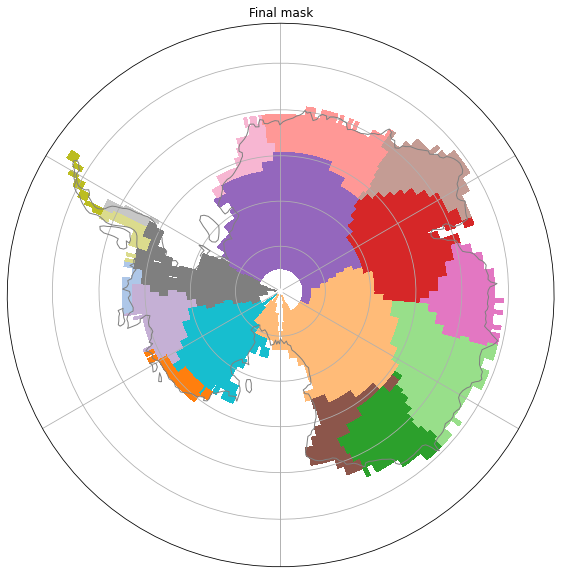

In [7]:
#%%
fig = plt.figure(figsize=(10,10), facecolor='w')
data=np.array(xda2.data)
data[data==0]=np.nan
ax1 = plt.subplot(1, 1, 1, 
                  # projection=ccrs.Robinson())
                    projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines(resolution='110m', zorder=3,color='grey') # zorder=3 makes sure that no other plots overlay the coastlines
ax1.gridlines()

theta = np.linspace(0, 2*np.pi, 100);center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T;circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
plt.pcolormesh(xda2.x,xda2.y,
                data,
                cmap='tab20',
                vmin=0,vmax=20,
                #extent=(0,1,0,1), origin='lower',
            transform=ccrs.PlateCarree()
            )
plt.title('Final mask')

plt.show()

In [8]:
#%% # fill inner circle:
lat=np.array(xda2.y)
lon=np.array(xda2.x)
mask=np.array(xda2.data)
llon,llat=np.meshgrid(lon,lat)
df=pd.DataFrame(llon.flatten(),columns=['lon'])
df['lat']=llat.flatten()
df['z']=mask.flatten()
#% %
df['z']=np.where(((df['z']==0) & (df['lat']<-85) & (df['lon']<120))
                 ,8,df['z'])
df['z']=np.where(((df['z']==0) & (df['lat']<-85) & (df['lon']>240))
                 ,8,df['z'])
df['z']=np.where(((df['z']==0) & (df['lat']<-85) & (df['lon']>120) & (df['lon']<240))
                 ,3,df['z'])
df['z']=np.where(((df['z']==0) )
                 ,np.nan,df['z'])

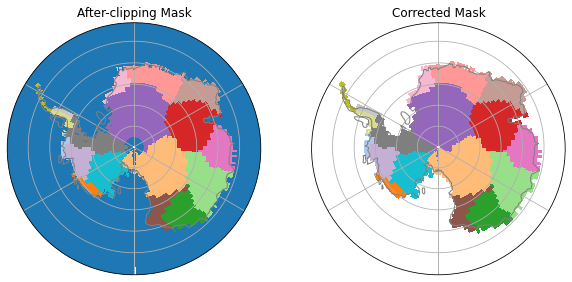

In [9]:
#%%
fig = plt.figure(figsize=(10,10), facecolor='w')
theta = np.linspace(0, 2*np.pi, 100);center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T;circle = mpath.Path(verts * radius + center)
ax1 = plt.subplot(1, 2, 1, 
                  # projection=ccrs.Robinson())
                    projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines(resolution='110m', zorder=3,color='grey') # zorder=3 makes sure that no other plots overlay the coastlines
ax1.gridlines()
ax1.set_boundary(circle, transform=ax1.transAxes)
plt.pcolormesh(xda2.x,xda2.y,
                # ds.mask, 
                xda2.data,
                # clipped,
                # ds.mask,
                # cmap='twilight',
                cmap='tab20',
                vmin=0,vmax=20,
                #extent=(0,1,0,1), origin='lower',
            transform=ccrs.PlateCarree()
            )
plt.title('After-clipping Mask')

ax1 = plt.subplot(1, 2, 2, 
                  # projection=ccrs.Robinson())
                    projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax1.coastlines(resolution='110m', zorder=3,color='grey') # zorder=3 makes sure that no other plots overlay the coastlines
ax1.gridlines()


ax1.set_boundary(circle, transform=ax1.transAxes)
plt.pcolormesh(np.array(df['lon']).reshape(180,360)[0,:],
               np.array(df['lat']).reshape(180,360)[:,0],
               np.array(df['z']).reshape(180,360),
               
                # xda2.x,xda2.y,
                # xda2.data,
                cmap='tab20',
                vmin=0,vmax=20,
                #extent=(0,1,0,1), origin='lower',
            transform=ccrs.PlateCarree()
            )
plt.title('Corrected Mask')

plt.show()